<a href="https://colab.research.google.com/github/hafilmr/LearningCodeTrainee/blob/main/Machine%20Learning%20Methods/ML_Stocks_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!pip install -U scikit-learn

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/sp500sub.csv

File ‘sp500sub.csv’ already there; not retrieving.



In [ ]:
df0 = pd.read_csv('sp500sub.csv',
                  index_col='Date',
                  parse_dates=True)

In [ ]:
df0.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [ ]:
df = df0[df0['Name'] == 'IBM'][['Close']].copy()

In [ ]:
df

,Close
Date,
2010-01-04,132.449997
2010-01-05,130.850006
2010-01-06,130.000000
2010-01-07,129.550003
2010-01-08,130.850006
...,...
2018-12-21,110.940002
2018-12-24,107.570000
2018-12-26,111.389999


In [ ]:
df['LogClose'] = np.log(df['Close'])

In [ ]:
df

,Close,LogClose
Date,,
2010-01-04,132.449997,4.886205
2010-01-05,130.850006,4.874052
2010-01-06,130.000000,4.867534
2010-01-07,129.550003,4.864067
2010-01-08,130.850006,4.874052
...,...,...
2018-12-21,110.940002,4.708990
2018-12-24,107.570000,4.678142
2018-12-26,111.389999,4.713038


In [ ]:
df['DiffLogClose'] = df['LogClose'].diff()

In [ ]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [ ]:
# Make supervised dataset
# lets see if we can use T past values to predict the next value

series = df['DiffLogClose'].to_numpy()[1:]

T = 21
x = []
y = []
for t in range(len(series) - T):
  X = series[t:t+T]
  x.append(X)
  Y = series[t+T]
  y.append(Y)

x = np.array(x).reshape(-1, T)
y = np.array(y)
N = len(x)
print('x.shape', x.shape, 'y.shape', y.shape)

x.shape (2241, 21) y.shape (2241,)


In [ ]:
xtrain, ytrain = x[:-Ntest], y[:-Ntest]
xtest, ytest = x[-Ntest:], y[-Ntest:]

In [ ]:
lr = LinearRegression()
lr.fit(xtrain, ytrain)
print('R2 Score for Train:', lr.score(xtrain, ytrain))

R2 Score for Train: 0.00910676388568632


In [ ]:
print('R2 Score for Tets:', lr.score(xtest, ytest))

R2 Score for Tets: -0.10647843085489161


In [ ]:
# Boolean Index

train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T+1] = False # first T+1 values are not predictable

In [ ]:
# Needed to compute un-differenced predictions
df['ShiftLogClose'] = df['LogClose'].shift(1)
prev = df['ShiftLogClose']

In [ ]:
# Last-known train value
last_train = train.iloc[-1]['LogClose']

In [ ]:
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(xtrain)
df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(xtest)

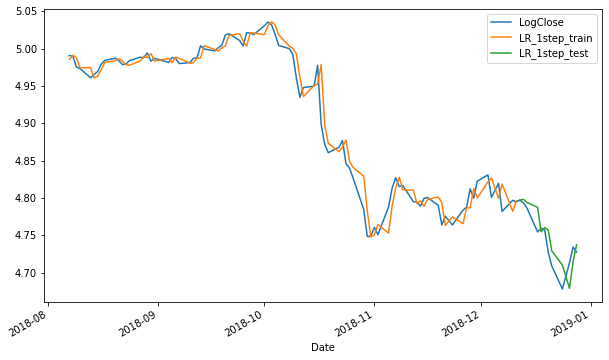

In [ ]:
# plot 1-step forecast
cols = ['LogClose', 'LR_1step_train', 'LR_1step_test']
df.iloc[-100:][cols].plot(figsize=(10,6))

It simply lags the input time series, which makes sense given what we know.


In [ ]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = xtest[0]

while len(multistep_predictions) < Ntest:
  p = lr.predict(last_x.reshape(1, -1))[0]

  # update the predictions list
  multistep_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [ ]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_predictions)

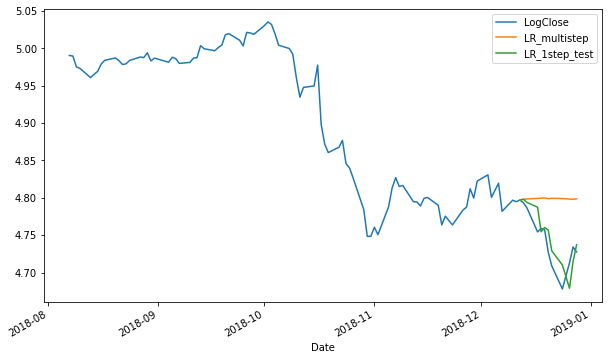

In [ ]:
# plto 1-step and multi-step forecast
cols = ['LogClose', 'LR_multistep', 'LR_1step_test']
df.iloc[-100:][cols].plot(figsize=(10, 6))

We see that the multistep forecast pretty much follows the straight line, which makes sense given what we know

In [ ]:
# Make multiouput forecast
Tx = T
Ty = Ntest
x = []
y = []
for t in range(len(series) - Tx - Ty + 1):
  X = series[t:t+Tx]
  x.append(X)
  Y = series[t+Tx:t+Tx+Ty]
  y.append(Y)

x = np.array(x).reshape(-1, Tx)
y = np.array(y).reshape(-1, Ty)
N = len(x)
print('x.shape', x.shape, 'y.shape', y.shape)

x.shape (2230, 21) y.shape (2230, 12)


In [ ]:
xtrain_m, ytrain_m = x[:-1], y[:-1]
xtest_m, ytest_m = x[-1:], y[-1:]

In [ ]:
lr = LinearRegression()
lr.fit(xtrain_m, ytrain_m)
print('R2 Score for Train Multioutput:', lr.score(xtrain_m, ytrain_m))

R2 Score for Train Multioutput: 0.010010133087048309


In [ ]:
r2_score(lr.predict(xtest_m).flatten(), ytest_m.flatten())

-489.94938006111647

In [ ]:
# save multi-output forecast
df.loc[test_idx, 'LR_multioutput'] = last_train + np.cumsum(lr.predict(xtest_m).flatten())

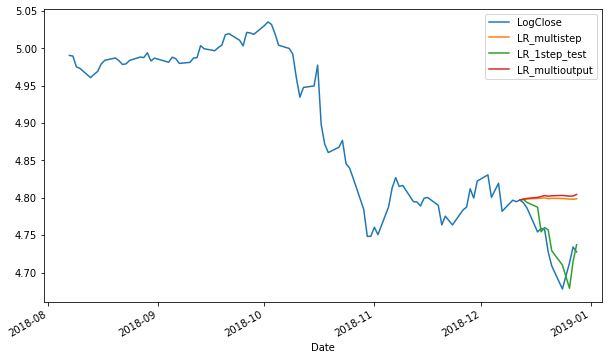

In [ ]:
# plot all forecast
cols = ['LogClose', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df.iloc[-100:][cols].plot(figsize=(10, 6))

We see that the multi output forecasts pretty much follows the same pattern.

In [ ]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogClose']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'LR_multistep'])
print('multi-step MAPE:', mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'LR_multioutput']
)
print('multi-output MAPE:', mape2)

multi-step MAPE: 0.01142632609085105
multi-output MAPE: 0.011998190671272594


## TEST OTHER MODELS

In [ ]:
def one_step_and_multistep_forecast(model, name):
  model.fit(xtrain, ytrain)
  print('one-step forecast:', name)

  # store 1 step forecast
  df.loc[train_idx, f'{name}_1step_train'] = prev[train_idx] + model.predict(xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = prev[test_idx] + model.predict(xtest)

  # store multi-step forecast
  df.loc[test_idx, f'{name}_multistep_test'] = last_train + np.cumsum(multistep_predictions)

  # MAPE of multi-step forecast
  mape = mean_absolute_percentage_error(
      test_log_pass, df.loc[test_idx, f'{name}_multistep_test']
  )
  print('Test MAPE (multi-step):', mape)

  # plot 1-step and multi-step forecast
  cols = [
          'LogClose',
          f'{name}_1step_train',
          f'{name}_1step_test',
          f'{name}_multistep_test',
  ]

  df.iloc[-100:][cols].plot(figsize=(10, 6));

one-step forecast: SVR
Test MAPE (multi-step): 0.01142632609085105


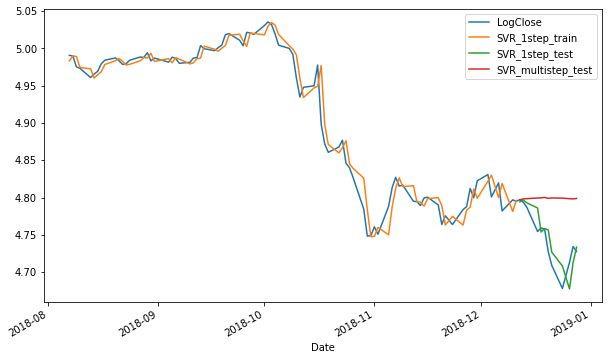

In [ ]:
one_step_and_multistep_forecast(SVR(), 'SVR')

SVR pretty much does the same thing

one-step forecast: RF
Test MAPE (multi-step): 0.01142632609085105


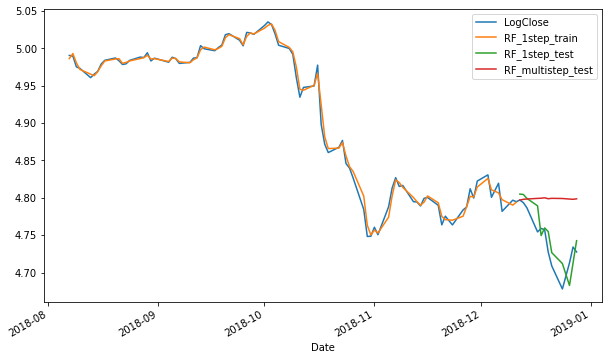

In [ ]:
one_step_and_multistep_forecast(RandomForestRegressor(), 'RF')

In [ ]:
def multi_output_forecast(model, name):
  model.fit(xtrain_m, ytrain_m)

  # save multi-output forecast to dataframe
  df.loc[test_idx, f'{name}_multioutput'] = last_train + np.cumsum(model.predict(xtest_m).flatten())

  mape = mean_absolute_percentage_error(
      test_log_pass, df.loc[test_idx, f'{name}_multioutput']
  )
  print('Test MAPE (multi-output):', mape)

  # plot all forecast
  # assume that previous functions have been run

  cols = [
          'LogClose',
          f'{name}_1step_train',
          f'{name}_1step_test',
          f'{name}_multistep_test',
          f'{name}_multioutput',
  ]

  df.iloc[-100:][cols].plot(figsize=(10, 6))

In [ ]:
# multi_output_forecast(SVR(), 'SVR') #cannot handle multioutput

Test MAPE (multi-output): 0.011244504378216613


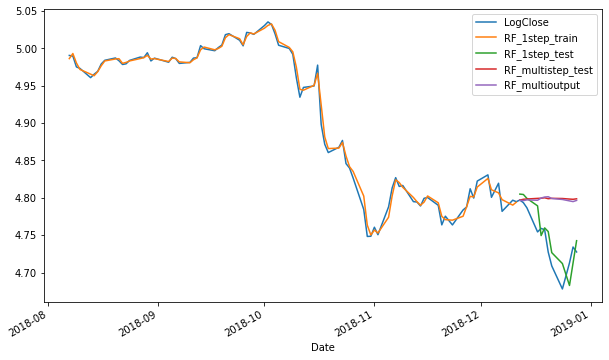

In [ ]:
multi_output_forecast(RandomForestRegressor(), 'RF')

It's pretty much the same results.

No surprise.


Now, what is the lesson of this example?

Well, you may have been hopeful that perhaps it was only linear models that would fail at predicting stock returns.

Maybe you hopes that there were some nonlinear patterns waiting to be exploited.

But so far, it turns out that this has not been the case.
